In [1]:
import logging
logging.basicConfig(level=logging.DEBUG)
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from ot_dis.wtk.utilities import get_ucr_dataset, krein_svm_grid_search
from ot_dis.wtk import transform_to_dist_matrix, get_kernel_matrix, wtk_distance
import numpy as np
import os
from getData import getData
from knn import knn_OTW
from ot_dis.kpg.kpg_fix import KeyPointGuidedOT
from ot_dis.wtk import subsequences
import ot
import torch

In [2]:
X_train, y_train, X_test, y_test = getData('BME', '../data/UCR/raw_data/')
m = int(len(X_train[0])/2)

In [4]:
xs = X_train[8]
xt = X_test[30]
subs_xs = subsequences(xs, 25)
subs_xt = subsequences(xt, 25)
p = np.ones(len(subs_xs))/len(subs_xs)
q = np.ones(len(subs_xt))/len(subs_xt)
subs_xs.shape, subs_xt.shape, len(p), len(q)

((104, 25), (104, 25), 104, 104)

c:\Users\Administrator\Documents\WTK-distance\venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
DEBUG:matplotlib:matplotlib data path: c:\Users\Administrator\Documents\WTK-distance\venv\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\Administrator\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32


[[ 9.61538462e-03 -3.12382355e-16 -2.31060601e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.97339646e-16  9.61538462e-03 -3.69421266e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.42929081e-15 -1.43970545e-16  9.61538462e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.61538461e-03
   1.88301769e-13  1.51288535e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.53773943e-13
   9.61538461e-03  1.67982238e-13]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.71185709e-13
   1.48088275e-13  9.61538462e-03]] 0.08130851946743467


DEBUG:matplotlib:CACHEDIR=C:\Users\Administrator\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\Administrator\.matplotlib\fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Administrator\\Documents\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\Administrator\\Documents\\WTK-distance\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', n

<Axes: >

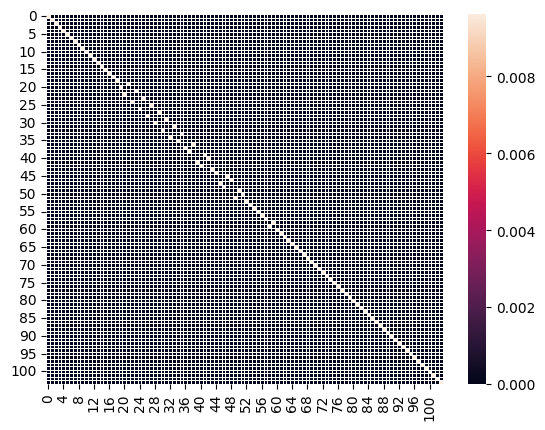

In [5]:
kgot = KeyPointGuidedOT()
pi, cost = kgot.kpg_rl_kp(p, q, subs_xs, subs_xt,3)
print(pi, cost)
import seaborn as sns
sns.heatmap(pi, linewidth=0.5)

In [7]:
def new_distance(a, b, kgot, sub_length=25):
    subs_xs = subsequences(a, 25)
    subs_xt = subsequences(b, 25)
    p = np.ones(len(subs_xs))/len(subs_xs)
    q = np.ones(len(subs_xt))/len(subs_xt)
    _, cost = kgot.kpg_rl_kp(p, q, subs_xs, subs_xt,3)
    return cost

In [8]:
from knn import knn_classifier_from_distance_matrix

In [19]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from ot_dis.wtk import wtk_distance
from ot_dis.otw import otw_distance
import time
def knn_WTK(X_train, X_test, y_train, y_test, data_set, sub_length=25,k=3):
    start_time = time.time()
    train_size = len(X_train)
    test_size = len(X_test)
    result = np.zeros((test_size, train_size))
    kgot = KeyPointGuidedOT()
    for train_idx in tqdm(range(train_size)):
        for test_idx in tqdm(range(test_size), leave=False):
            distance = new_distance(X_train[train_idx], X_test[test_idx], kgot=kgot)
            result[test_idx, train_idx] = distance
    
    y_pred = knn_classifier_from_distance_matrix(
        distance_matrix=result,
        k=k,
        labels=y_train,
    )
    accuracy = accuracy_score(y_test, y_pred)
    end_time = time.time()
    return accuracy

In [20]:
accuracy = knn_WTK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, data_set="BME", k=1)

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\Administrator\Documents\WTK-distance\venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
100%|██████████| 30/30 [04:41<00:00,  9.38s/it]


In [21]:
accuracy

0.7266666666666667